# Assignment Day 1

## Team members:
- Samuel Nebgen s6sanebg@uni-bonn.de
- Muhammad Humza Arain s27marai@uni-bonn.de
- Julian Meigen s82jmeig@uni-bonn.de

## 08.09.2025

Contributions were made by all team members in around the same amount, either based on discussions or coding.

## Flu trends dataset: Understanding your data and applying the ARIMA model

This notebook contains the tasks to analyze the flu trends dataset and to apply the ARIMA model on it. The dataset contains the Google Trends data for various flu-related search terms as well as the weekly office visits for the flu (FluVisits column). You can find the dataset in data/flu_trends.csv. Install required packages and complete the notebook.

Throughout the seminar, we will use the following splits for training, validation, and testing. Make sure to keep the tests unseen until the final evaluation (information leakage):
- Training set: 2009-2013
- Validation set: 2014
- Test set: 2015-2016

Required python packages: pandas, numpy, matplotlib, scikit-learn, statsmodels, pmdarima

In [1]:
# Install required packages

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import pmdarima as pm
import os


## Task 1: Data Exploration

**Task 1.1:** Load the dataset and display the first few rows to understand the structure of the data. Check the data types of each column and convert the week column to a more usable datetime format.

In [3]:
filepath = os.path.join('..', 'data', 'raw', 'flu-trends.csv')

In [4]:
flu_data_testing = pd.read_csv(filepath)
flu_data_testing[["start_date", "end_date"]] = flu_data_testing["Week"].str.split("/", expand=True)
flu_data_testing["start_date"] = pd.to_datetime(flu_data_testing["start_date"], format="%Y-%m-%d")
flu_data_testing["end_date"]   = pd.to_datetime(flu_data_testing["end_date"], format="%Y-%m-%d")

df = flu_data_testing.set_index(["start_date", "end_date"])
df.drop(columns=["Week"], inplace=True)
df.head(10)


#We decided to keep the start and end date as a multi-index to make it easier to use while still keeping all the information.

,,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
start_date,end_date,,,,,,,,,,,,,,,,,,,,,
2009-06-29,2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06,2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13,2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20,2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27,2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120
2009-08-03,2009-08-09,28,23,39,8,6,18,13,8,7,8,...,8,9,16,18,30,13,26,26,17,115
2009-08-10,2009-08-16,29,22,41,35,10,17,15,7,10,8,...,8,11,10,28,32,21,17,25,13,123
2009-08-17,2009-08-23,29,20,43,32,9,20,20,10,13,22,...,8,9,10,24,29,13,23,27,14,205
2009-08-24,2009-08-30,27,19,52,27,7,22,16,13,16,19,...,15,13,18,26,43,29,27,26,17,454


**Task 1.2:** Are there any missing values in the dataset? If so, how would you handle them?

In [5]:
df.isna().sum()

AInfluenza                 0
AcuteBronchitis            0
BodyTemperature            0
BraunThermoscan            0
BreakAFever                0
                          ..
TypeAInfluenza             0
UpperRespiratory           0
WalkingPneumonia           0
WhatToDoIfYouHaveTheFlu    0
FluVisits                  0
Length: 130, dtype: int64

In [6]:
df.where(df >= 0, np.nan).isna().sum().sum()

0

There are no nans/negative numbers in the Dataframe. If there were, we could either drop the rows with nans, which would lead to holes in the time series and maybe to problems further down the line. 
Alternatively, we could fill the nans with the mean or median of the respective column, which might also be problematic, as there are probably seasonal trends in the data that both median and mean would not capture. 
A more sophisticated approach would be to use interpolation between neighbors to fill the nans.

**Task 1.3:** Provide summary statistics for the dataset.

In [7]:
df.describe()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,...,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,12.478142,44.683060,59.926230,31.836066,27.565574,43.428962,39.510929,24.844262,18.478142,11.270492,...,12.412568,7.275956,14.382514,38.439891,33.081967,13.352459,53.292350,50.844262,12.904372,386.745902
std,13.648556,17.114861,11.346958,11.087963,13.876355,15.097097,15.631322,16.294391,14.847842,11.276381,...,12.353991,6.586647,10.913163,11.130383,12.352754,16.965358,16.785163,17.100519,12.735416,616.914602
min,2.000000,14.000000,36.000000,8.000000,6.000000,17.000000,11.000000,3.000000,1.000000,2.000000,...,3.000000,1.000000,2.000000,15.000000,13.000000,1.000000,17.000000,22.000000,0.000000,10.000000
25%,4.000000,32.000000,50.000000,25.000000,19.000000,31.000000,28.000000,12.000000,8.000000,5.000000,...,5.000000,3.000000,8.000000,30.000000,24.000000,4.000000,41.000000,36.000000,6.000000,37.250000
50%,7.000000,43.000000,60.000000,30.000000,25.000000,42.500000,37.000000,22.000000,15.000000,8.000000,...,8.000000,6.000000,12.000000,37.000000,30.000000,6.000000,52.000000,49.000000,9.000000,106.000000
75%,14.000000,55.000000,68.000000,37.000000,32.750000,53.000000,50.000000,33.000000,23.000000,13.000000,...,15.000000,9.000000,17.000000,45.750000,40.000000,14.000000,66.000000,63.000000,14.000000,435.500000
max,82.000000,100.000000,100.000000,88.000000,100.000000,100.000000,100.000000,100.000000,100.000000,87.000000,...,93.000000,53.000000,81.000000,74.000000,87.000000,100.000000,100.000000,100.000000,89.000000,4070.000000


In [8]:
df.shape

(366, 130)

**Task 1.4:** Plot the weekly FluVisits over time to visualize trends and patterns. Compare with a few of the search trends. What do you observe?

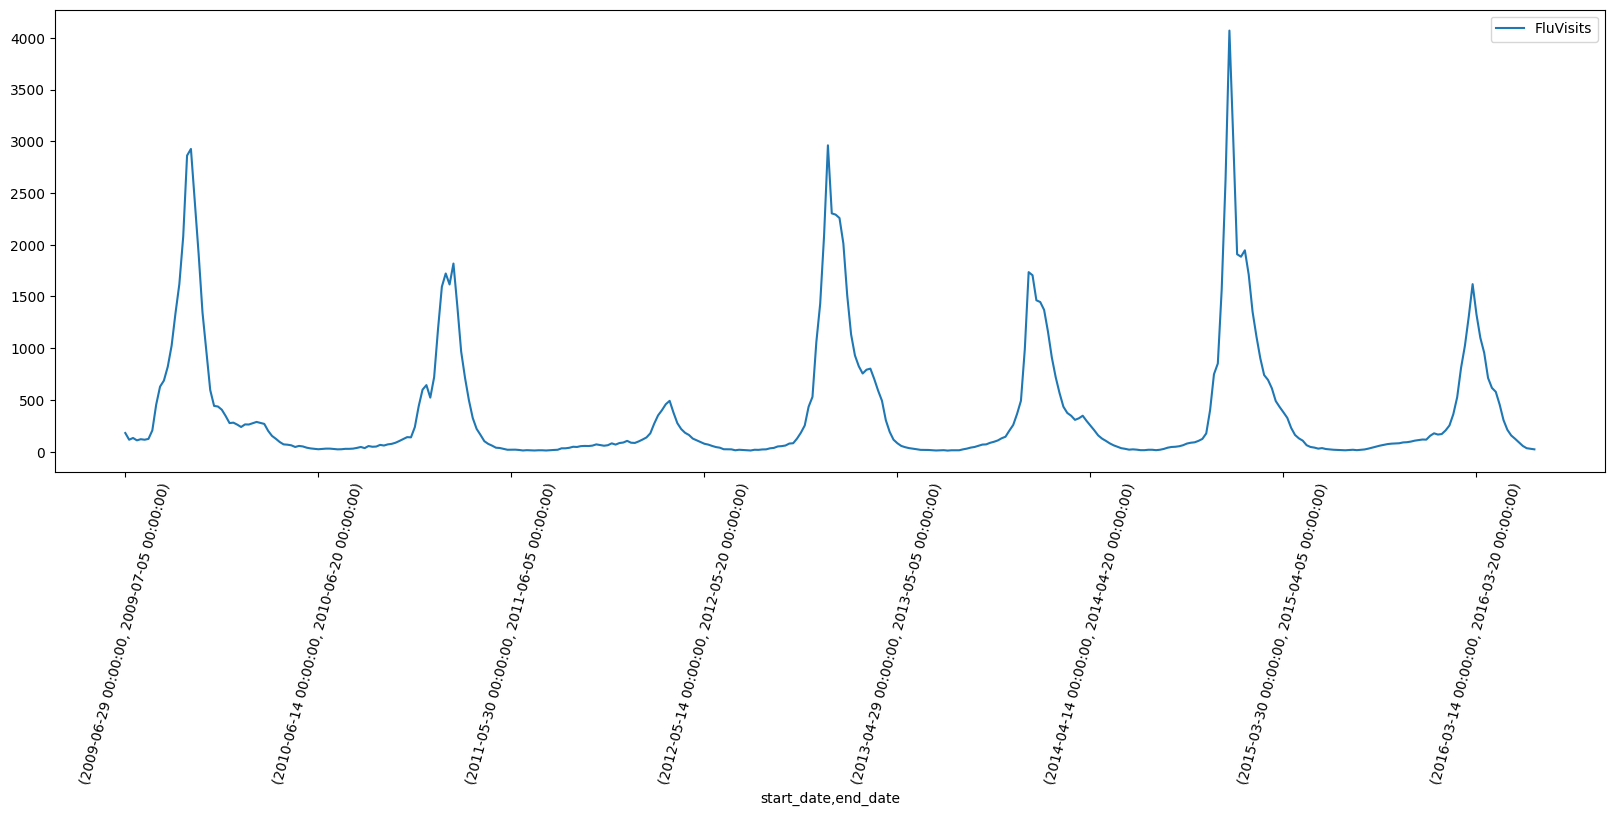

In [9]:
ax = df.plot(y='FluVisits', use_index=True, figsize=(20, 6))

ax.tick_params(axis='x', rotation=75)
plt.show()

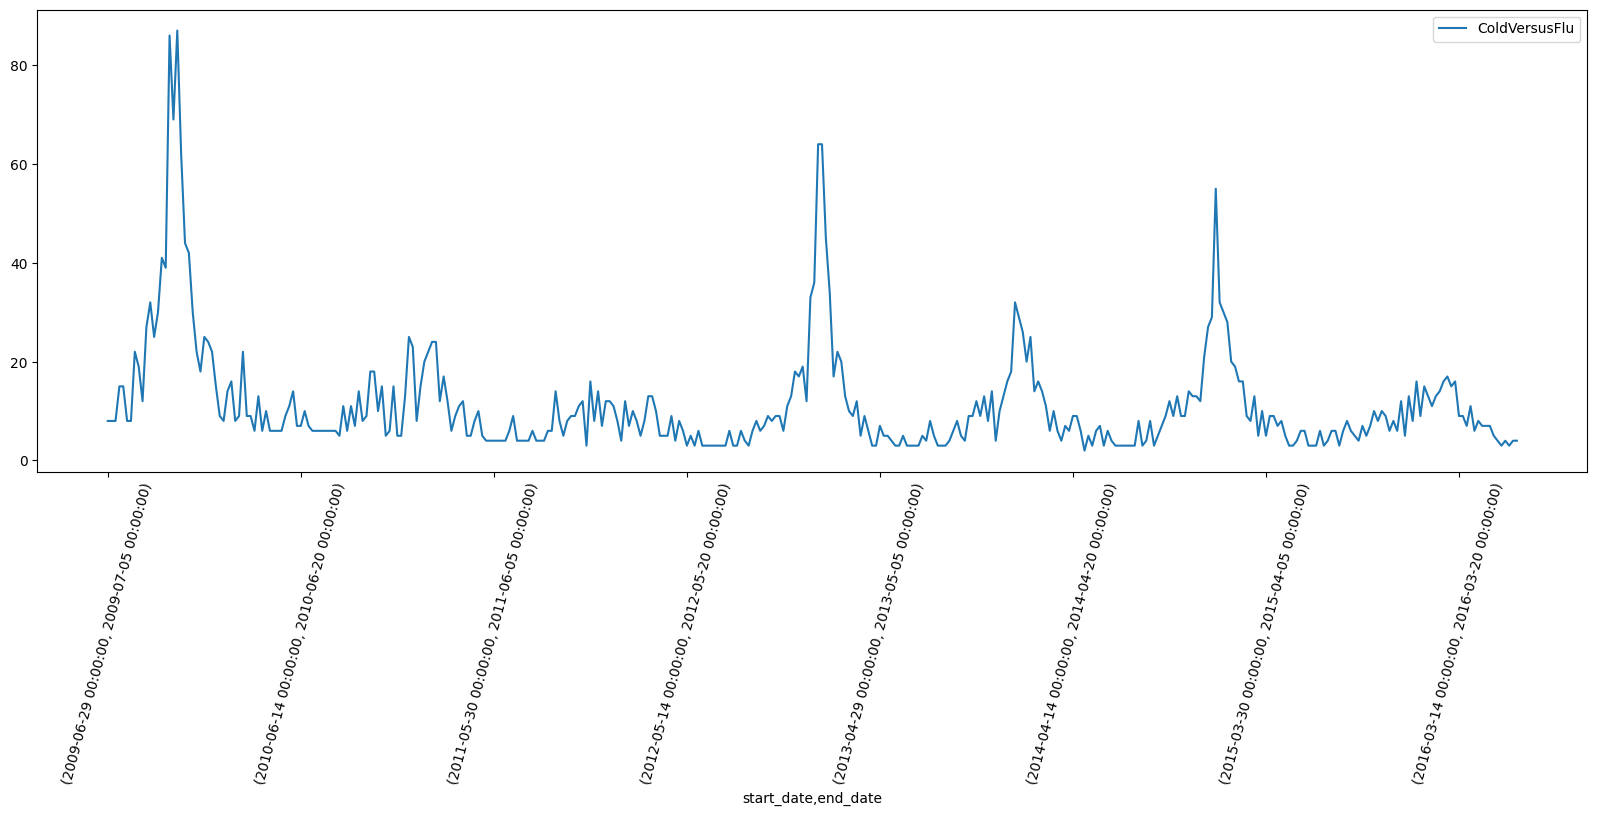

In [10]:
ax = df.plot(y='ColdVersusFlu', use_index=True, figsize=(20, 6))
ax.tick_params(axis='x', rotation=75)
plt.show()


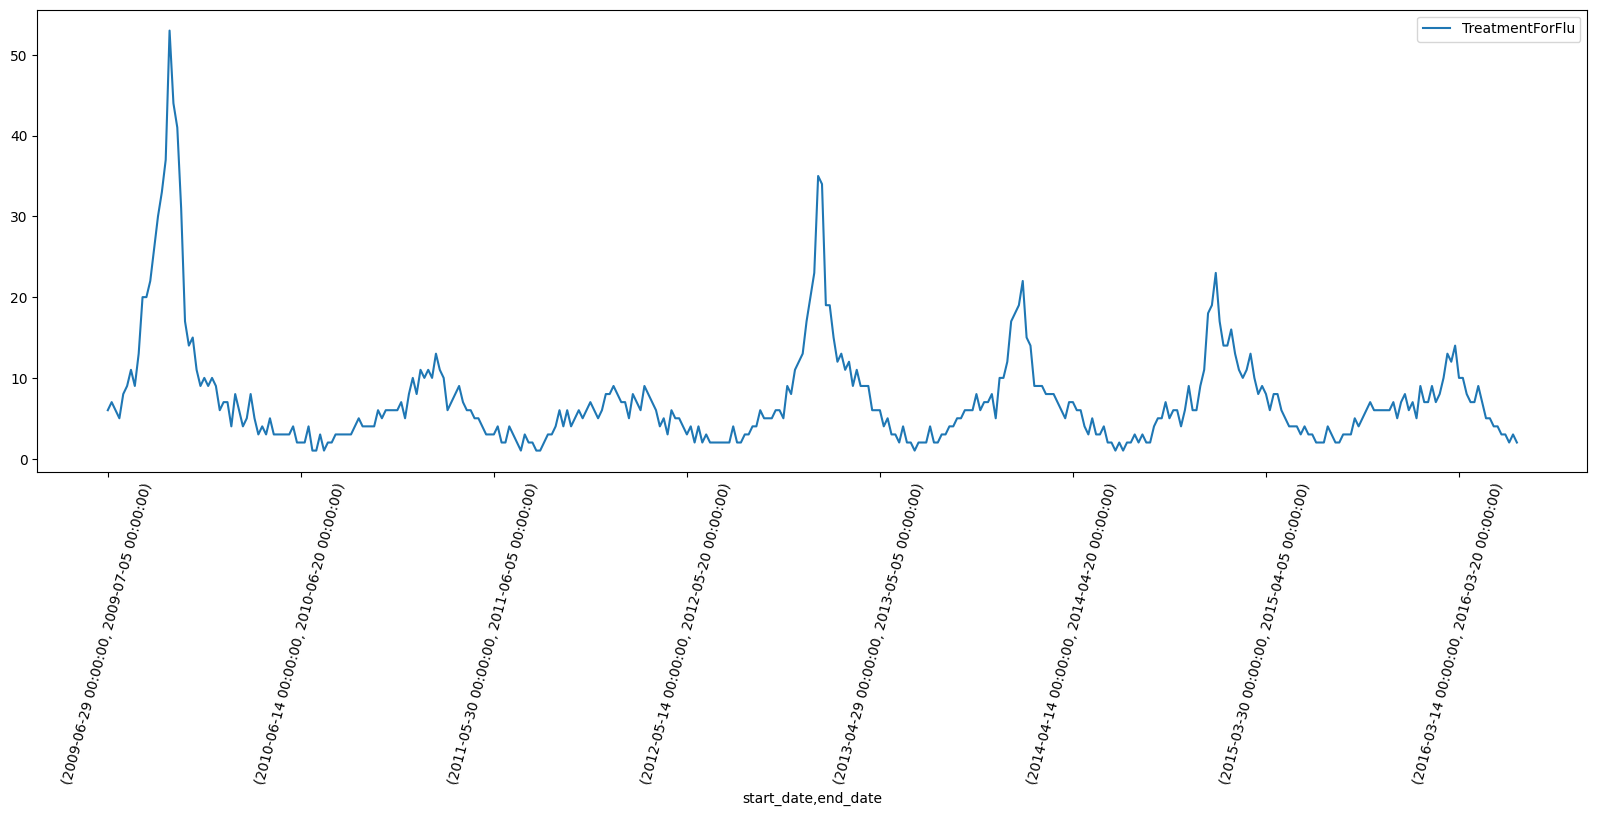

In [11]:
ax = df.plot(y='TreatmentForFlu', use_index=True, figsize=(20, 6))
ax.tick_params(axis='x', rotation=75)
plt.show()

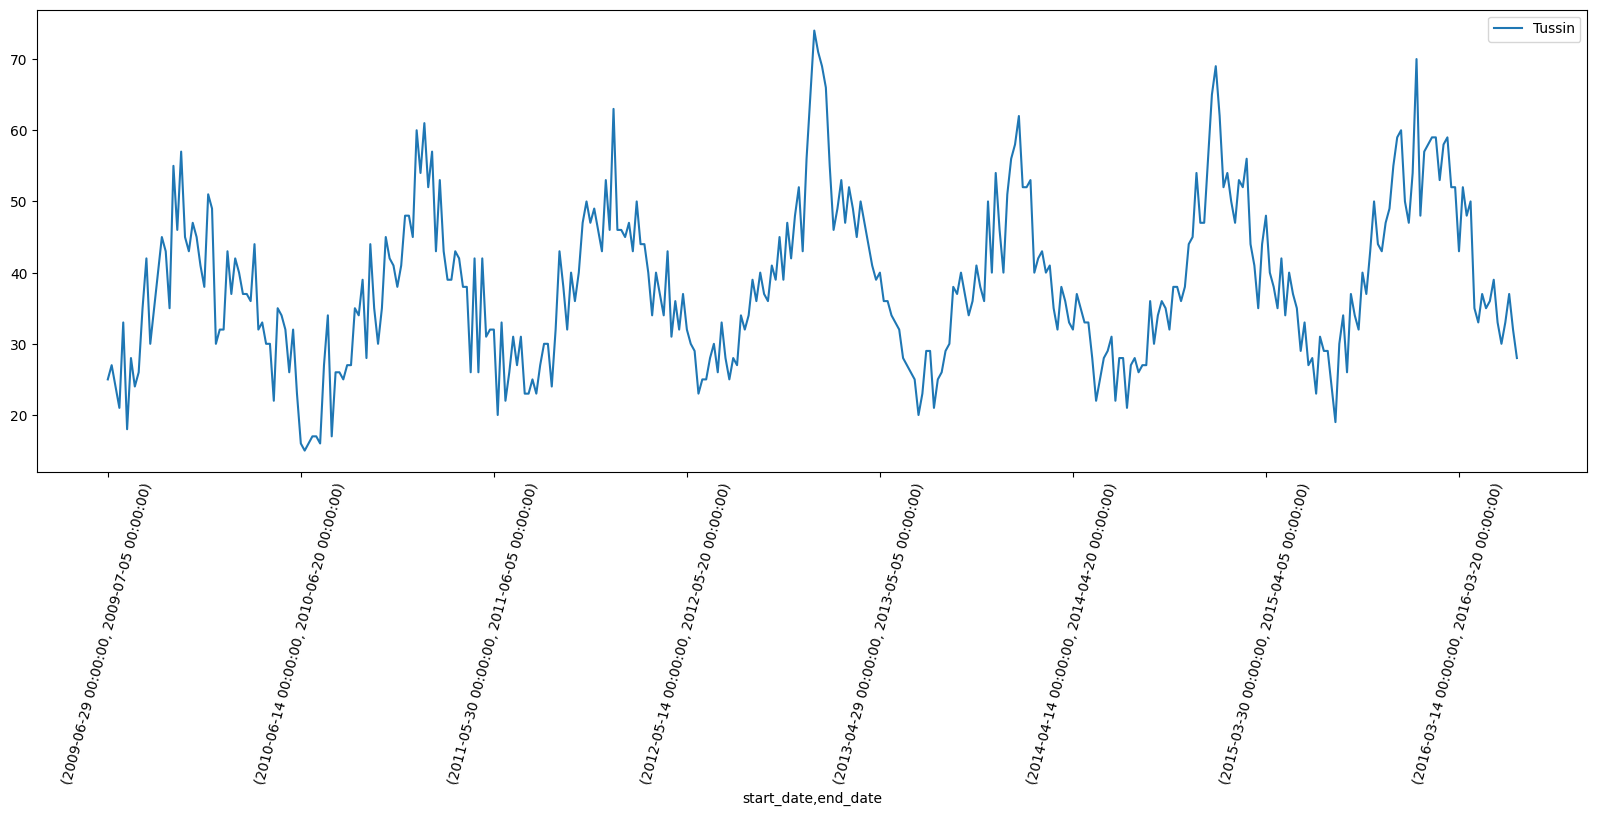

In [12]:
ax = df.plot(y='Tussin', use_index=True, figsize=(20, 6))
ax.tick_params(axis='x', rotation=75)
plt.show()

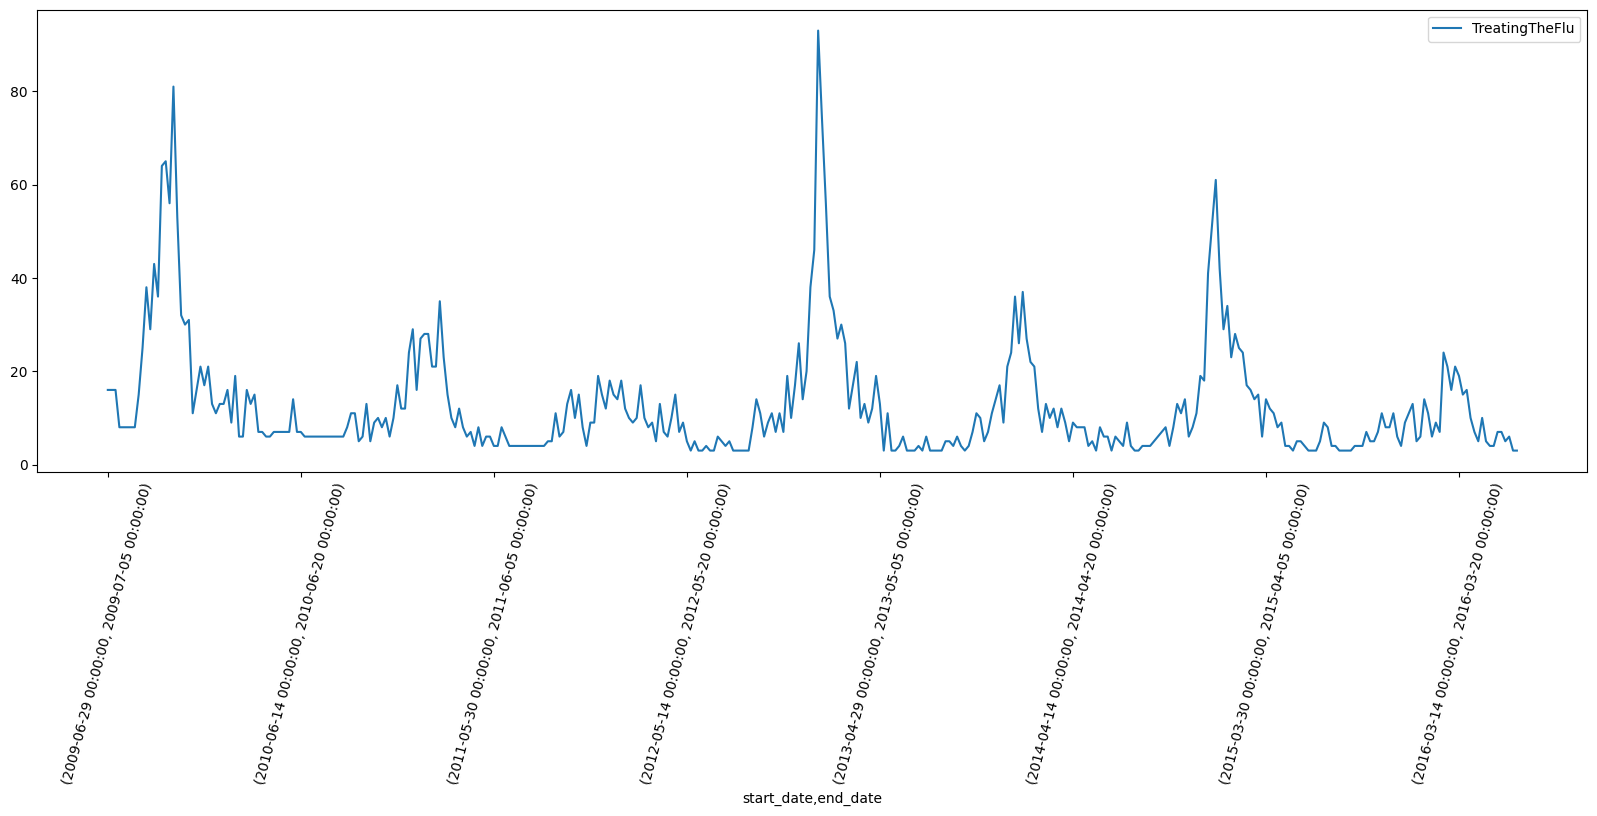

In [13]:
ax = df.plot(y='TreatingTheFlu', use_index=True, figsize=(20, 6))
ax.tick_params(axis='x', rotation=75)
plt.show()

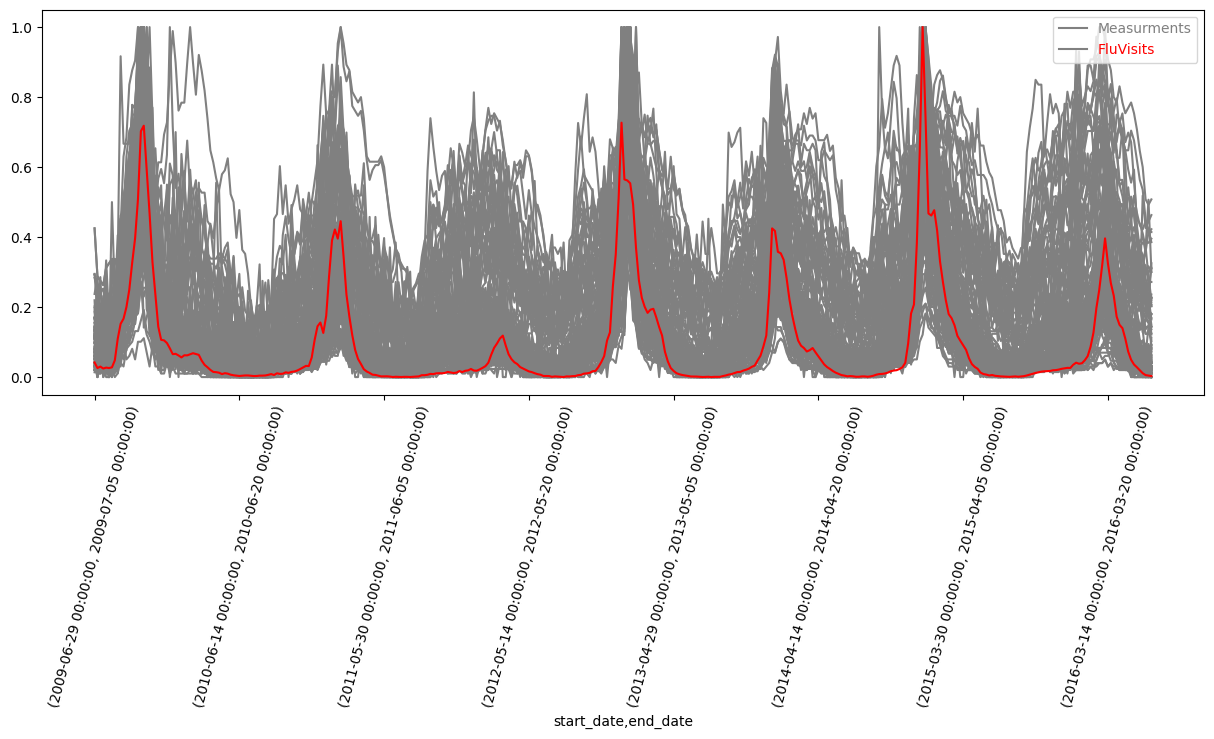

In [14]:
df_norm = (df - df.min()) / (df.max() - df.min())
ax = df_norm.plot(y=df_norm.columns,figsize=(15, 5), color=['gray' for _ in range(len(df_norm.columns)-1)] + ['red'])
ax.legend(["Measurments", "FluVisits"], labelcolor=['gray', 'red'])
ax.tick_params(axis='x', rotation=75)
plt.show()

In [15]:
before_visit = [
    "DoIHaveTheFlu",      
    "EarlyFluSymptoms",    
    "ExposedToFlu",        
    "FeverFlu",            
    "FluTest"              
]
after_visit = [
    "FluTreatment",        
    "FluMedicine",         
    "FluRecovery",         
    "RemediesForFlu",     
    "WhatToDoIfYouHaveTheFlu" 
]

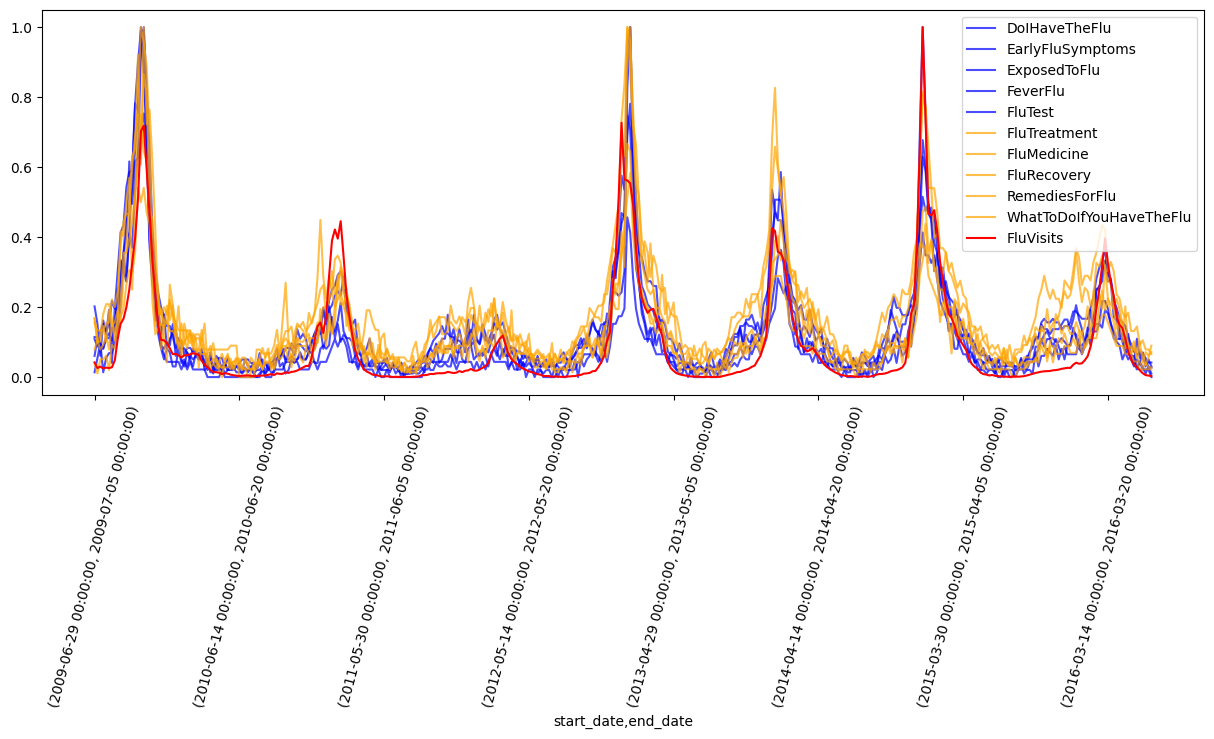

In [16]:
fig, ax= plt.subplots()
df_norm[before_visit].plot(figsize=(15, 5), color='blue', legend=False, ax=ax, label='Before Visit', alpha=0.7)
df_norm[after_visit].plot(figsize=(15, 5), color='orange', legend =False, ax=ax, label='After Visit', alpha=0.7)
df_norm["FluVisits"].plot(figsize=(15, 5), color='red', legend=False, ax=ax, label='FluVisits')
ax.tick_params(axis='x', rotation=75)
ax.legend()

There are clear seasonal fluctuations in the data with peaks in the flu season. We also had a theory that people might search for flu symptoms before they actually visit the doctor and search for treatments afterwards, which would lead to a slight shift of the peaks. We selected some variables that we thought would show this behavior, but we could not observe it clearly in the last plot. Some Variables like the tussin drug show not a super clear correlation, probably because people search for it when they have a cold or other diseases that can be treated with it too.'

**Task 1.5:** Group the data by month and calculate the average number for each month. Create a bar plot to visualize the monthly averages, which will help identify any seasonal patterns. Check how the number of cases develops over the years.


In [17]:
start_month = df.index.get_level_values("start_date").month # had to do it like this because of the multi index instead of using the simpler df.index.month directly 
df.groupby(start_month).mean()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
start_date,,,,,,,,,,,,,,,,,,,,,
1,24.166667,60.066667,72.066667,43.200000,39.233333,60.600000,56.500000,45.833333,38.766667,21.633333,...,26.100000,12.933333,25.433333,52.733333,46.300000,28.100000,66.900000,74.433333,25.200000,969.000000
2,20.206897,62.241379,69.586207,38.413793,37.379310,59.068966,53.068966,35.586207,27.896552,14.379310,...,18.482759,9.655172,19.896552,47.862069,39.689655,21.344828,67.517241,67.896552,19.137931,775.931034
3,16.354839,56.677419,62.548387,33.451613,34.322581,52.096774,43.741935,26.258065,18.967742,9.322581,...,12.419355,7.903226,15.677419,41.451613,36.677419,15.903226,62.806452,58.419355,13.419355,534.483871
4,10.166667,46.733333,60.800000,28.533333,26.933333,44.233333,34.800000,18.366667,12.633333,7.066667,...,8.800000,6.100000,13.433333,36.433333,29.200000,9.600000,55.000000,46.666667,11.600000,226.066667
5,5.806452,39.225806,53.451613,25.580645,23.903226,36.903226,29.741935,13.903226,9.064516,5.290323,...,5.645161,3.709677,9.193548,33.032258,25.838710,5.161290,46.096774,40.290323,7.258065,74.774194
6,4.354839,32.709677,47.516129,24.290323,21.258065,29.354839,26.193548,10.516129,6.258065,4.677419,...,5.064516,2.774194,6.612903,26.290323,21.870968,3.870968,41.161290,33.677419,5.258065,30.870968
7,5.866667,26.933333,46.633333,22.833333,18.766667,23.900000,21.833333,8.166667,5.333333,5.433333,...,5.933333,2.666667,5.700000,25.966667,21.766667,5.800000,34.600000,29.733333,5.033333,29.766667
8,7.156250,27.031250,48.843750,23.937500,17.125000,24.625000,24.500000,11.750000,7.468750,6.312500,...,5.312500,3.968750,7.125000,26.968750,23.812500,5.875000,34.718750,31.156250,6.906250,65.093750
9,9.400000,37.833333,66.600000,32.000000,22.066667,36.833333,36.600000,24.333333,16.033333,9.633333,...,10.500000,7.100000,12.333333,34.800000,31.133333,10.600000,52.566667,42.466667,11.866667,168.333333


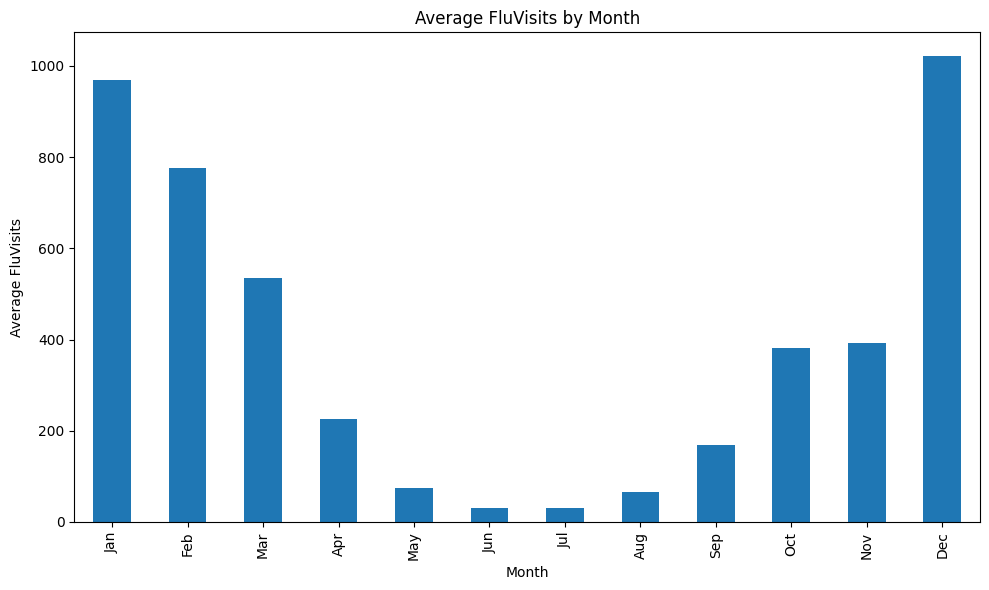

In [18]:

start_month = df.index.get_level_values("start_date").month
monthly_means = df.groupby(start_month)["FluVisits"].mean()

monthly_means.index = monthly_means.index.map({1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"})

ax = monthly_means.plot(kind="bar", figsize=(10,6))
ax.set_xlabel("Month")
ax.set_ylabel("Average FluVisits")
ax.set_title("Average FluVisits by Month")

plt.tight_layout()
plt.show()


There are clear seasonal trends in the data, with peaks in the winter months and decreases of flu visits over the summer months. 

## Task 2: Stationarity and Autocorrelation

**Task 2.1:** Apply the Augmented Dickey-Fuller test to check for stationarity. Explain the results and the implications for time series modeling.

In [19]:
# because we do not want to have any data leakage, we will split the data into training, validation and test set based on the given times before applying the augmented 
# dickey fuller test on the data.
start = df.index.get_level_values("start_date") # we decided to use the start date for splitting the data, so if a row starts in 2013 and ends in 2014, we will still count it 
                                                                  # in the Training set

train = df[(start >= pd.Timestamp("2009-01-01")) & (start < pd.Timestamp("2013-12-31"))]
val   = df[(start >= pd.Timestamp("2014-01-01")) & (start < pd.Timestamp("2014-12-31"))]
test  = df[(start >= pd.Timestamp("2015-01-01"))]

train.head()
train.shape


(236, 130)

In [20]:
test.head()
test.shape

(78, 130)

In [21]:
val.head()
val.iloc[-1]
val.shape

(52, 130)

In [22]:
train.to_csv(os.path.join('..', 'data', 'interim', 'training.csv'))
test.to_csv(os.path.join('..', 'data', 'interim', 'test.csv'))
val.to_csv(os.path.join('..', 'data', 'interim', 'validation.csv'))

In [23]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(train['FluVisits'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.744370
p-value: 0.003531


Because the p-value is below the threshold of 0.05, we can reject the null hypothesis that the time series data is non-stationary, see https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/. Therefore, no differencing is required and we can set the d parameter of the ARIMA model to 0. 

**Task 2.2:** Investigate Autocorrelation by plotting the Autocorrelation Function (ACF) and the partial Autocorrelation Function (PACF) for the FluVisits column. Determine appropriate values for the AR (p) and MA (q) parameters of the ARIMA model based on these plots.

> Hint: The statsmodels package provides usesful functions for that purpose.  
> If you want to read more about the ACF and PACF, you can check this [link](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/).

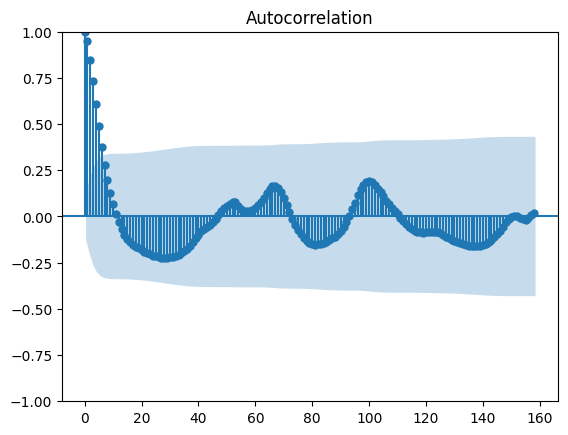

In [24]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train['FluVisits'], lags=158)
plt.show()

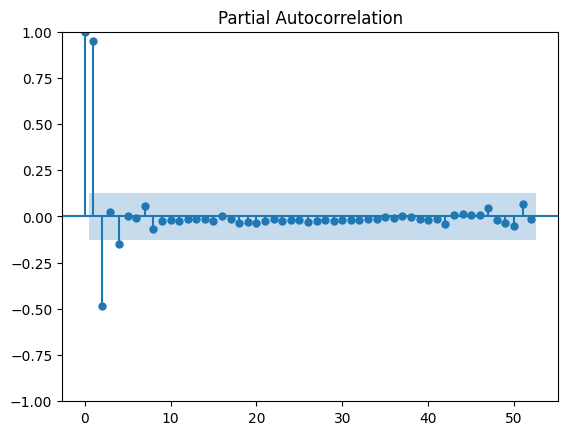

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train['FluVisits'], lags=52)
plt.show()

Explain your visualizations and findings. Specifically, comment on the trends, seasonality, and autocorrelation. Explain why it is important to do these checks before applying the ARIMA model.

Based on the Autocorrelation Plot, we can see that there is a clear correlation of the FluVisits with the past 6-7 values, with the highest influence being the previous week. This is to be expected, as flu infections often last for multiple weeks and the number of visits in one week is likely to influence the number of visits in the following week, with a decreasing influence over time. Based on this, the q parameter of the ARIMA model should be set to 1
Based on the Partial Autocorrelation Plot, we can see that there is a clear cutoff after 2 weeks, with the highest influence being the previous week. This suggests that the p parameter of the ARIMA model should also be set to 1. 

**Task 2.3:** Create lag plots for the FluVisits column to visualize the relationship between the current value and its past values. Comment on the patterns you observe in the lag plots.

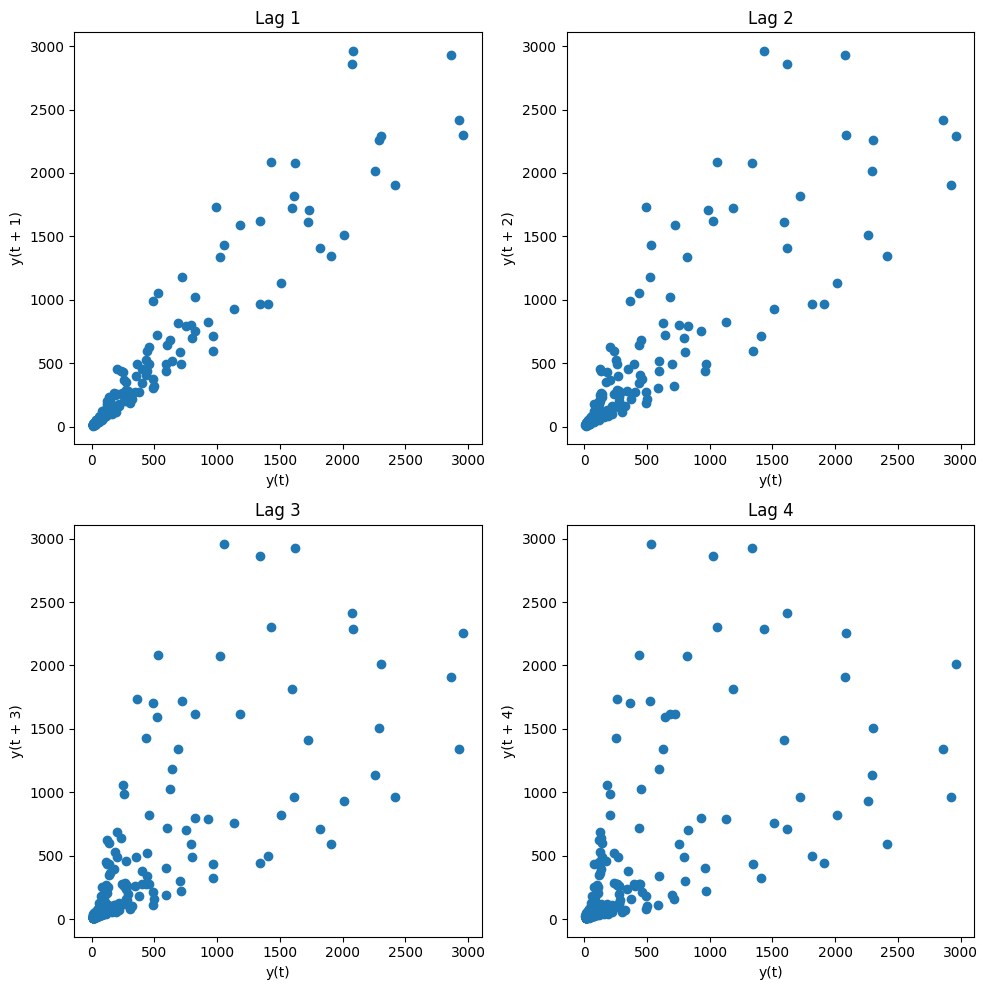

In [26]:
lags = [1, 2, 3, 4]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax, lag in zip(axes.flatten(), lags):
    pd.plotting.lag_plot(train["FluVisits"], lag=lag, ax=ax)
    ax.set_title(f"Lag {lag}")

plt.tight_layout()
plt.show()

For a lag of 1, we can see a almost linear relationship between the current value and the next value, so many flu visits in one week often lead to many flu visits in the next week and if there are only a few flu visits in one week there will be only a few flu visits in the next week. We can see similar patterns for increasing lags, with a more spread out distribution for higher lags, as the influence of the current value decreases with increasing lag.

## Task 3: Application of the AR(I)MA Model

The ARIMA (AutoRegressive Integrated Moving Average) model is a popular time series forecasting model that combines three components:

1. **AR (AutoRegressive)**: Uses the dependent relationship between an observation and some number of lagged observations.
2. **I (Integrated)**: Represents the differencing of raw observations to allow the time series to become stationary.
3. **MA (Moving Average)**: Uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

ARIMA is denoted as ARIMA(p,d,q), where:
- p: The order of the autoregressive term
- d: The number of differencing required to make the time series stationary
- q: The order of the moving average term

For further information, you can refer to e.g. this [tutorial](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/). 

Many Python packages provide implementations for the ARIMA model, but in this seminar, we will use the [pmdarima](pmdarima) package. The pmdarima package provides an easy-to-use interface for the ARIMA model and automatically selects the best parameters.

**Task 3.1:** Prepare your data for the ARIMA model. In the upcoming days, you will use the years 2015-2016 for testing and therefore you should also get the predictions for these years with the ARIMA model. Prepare the data accordingly. What input is expected by the model?

In [27]:
# Because we have already prepared the data and split it into a training and test set, we can directly use the training set to fit the model.
# The Model expects the parameters p: the order of the autoregressive term, d: The number of differencing required to make the time series stationary,
# q: the order of the moving average term and of course the training data itself.

**Task 3.2:** Use the auto_arima function from the pmdarima package to find the best parameters for the ARIMA model.

In [28]:

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    model = pm.auto_arima(train.FluVisits, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      d=None,           # let model determine 'd'
                      seasonal=True,   # with seasonality
                      m=52,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=2998.906, Time=1.70 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3092.998, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2996.109, Time=0.86 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3012.804, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3091.329, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=3009.414, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=2996.468, Time=5.86 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=2996.929, Time=1.35 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=2998.455, Time=0.84 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=2998.253, Time=11.26 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=3086.281, Time=0.63 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=2998.090, Time=1.17 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2998.089, Time=1.20 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=3011.318, Time=0.88 sec
 ARIMA(2,1,1)(1,0,

In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  236
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 52)   Log Likelihood               -1494.069
Date:                            Mon, 08 Sep 2025   AIC                           2994.137
Time:                                    19:53:18   BIC                           3004.516
Sample:                                         0   HQIC                          2998.322
                                            - 236                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5708      0.022     25.714      0.000       0.527       0.614
ar.S.L52       0.2823      0.060      4.701      0.000       0.165       0.400
sigma2       1.91e+04    706.313     27.046      0.000    1.77e+04    2.05e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5522.85
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.28   Skew:                            -2.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Task 3.3:** Fit the ARIMA model with the best parameters and make predictions for the test set (2015-2016). Evaluate the model using suitable metrics.

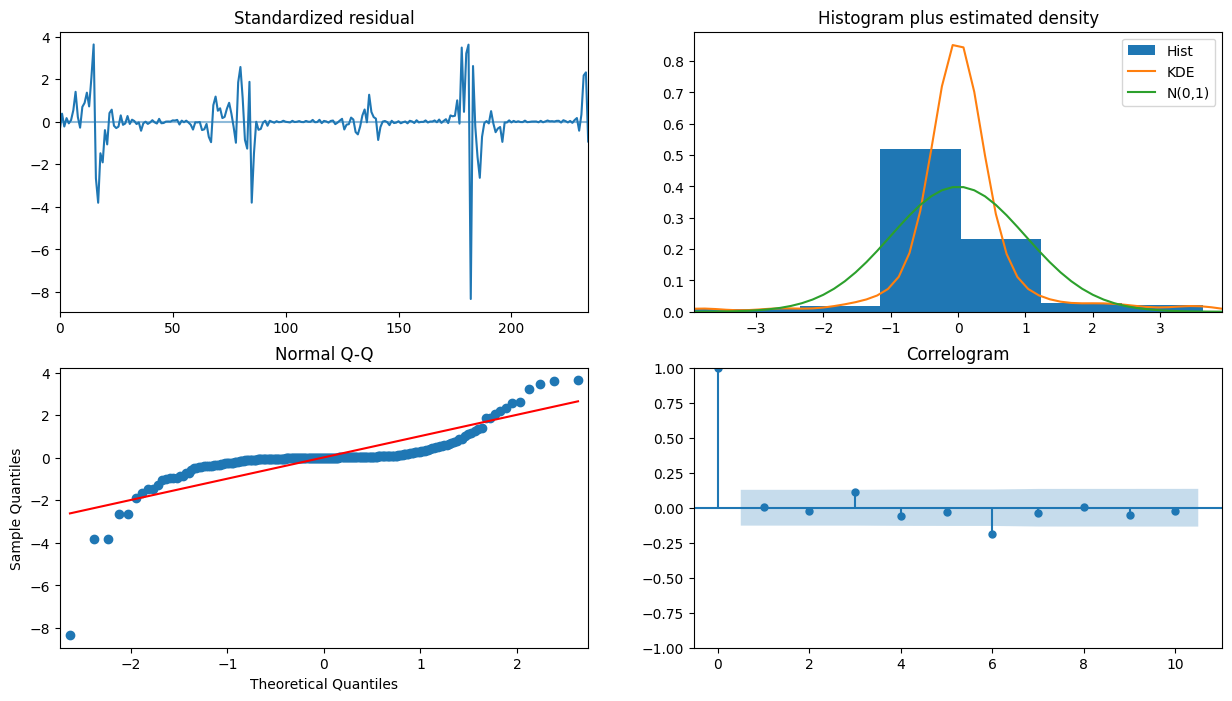

In [30]:
# after running the auto_arima function, the model with the optimal parameters is already fitted, so we can directly plot the diagnostics to check if the model is a good fit for the data.
model.plot_diagnostics(figsize=(15, 8))
plt.show()

c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine lea

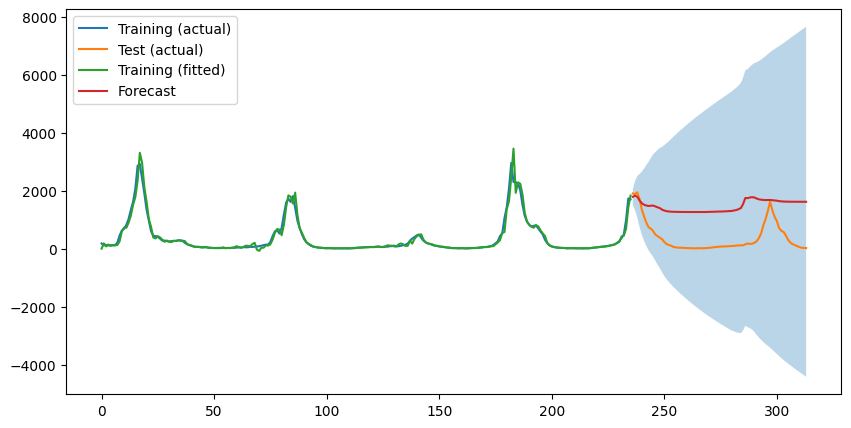

In [33]:
# also showing how well the model fits the training data

x_train = np.arange(len(train))
x_test  = np.arange(len(train), len(train) + len(test))
yhat, ci = model.predict(n_periods=len(test), return_conf_int=True)

plt.figure(figsize=(10,5))
plt.plot(x_train, train.FluVisits, label="Training (actual)")
plt.plot(x_test,  test.FluVisits,  label="Test (actual)")
plt.plot(x_train, model.predict_in_sample(), label="Training (fitted)")
fc, ci = model.predict(n_periods=len(test), return_conf_int=True)
plt.plot(x_test, fc, label="Forecast")
plt.fill_between(x_test, ci[:,0], ci[:,1], alpha=0.3)
plt.legend(); plt.show()


In [34]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test.FluVisits, yhat)
print(f"Mean Absolute Percentage Error: {mape:.2%}")

Mean Absolute Percentage Error: 2097.72%


In [ ]:
# Also testing how well the manually predicted parameters absed on Task 2 work
manual_model = pm.ARIMA(order=(1,0,1), seasonal_order=(1,0,0,52))
manual_model.fit(train.FluVisits)

# Forecast
forecast, conf_int = manual_model.predict(n_periods=len(test), return_conf_int=True)

n_periods = len(test)
yhat_manual = manual_model.predict(n_periods=n_periods)


c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  236
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 52)   Log Likelihood               -1505.347
Date:                             Mon, 08 Sep 2025   AIC                           3020.694
Time:                                     19:51:12   BIC                           3038.013
Sample:                                          0   HQIC                          3027.675
                                             - 236                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     21.9378     32.588      0.673      0.501     -41.933      85.808
ar.L1          0.9305      

c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine lea

c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine lea

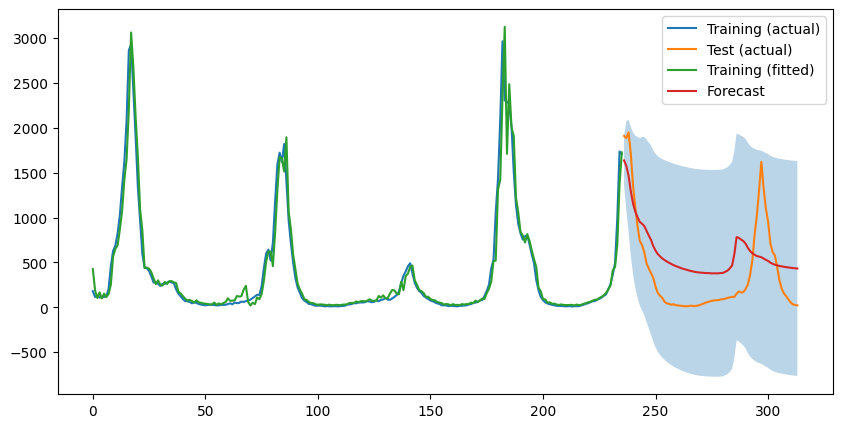

In [ ]:
# also showing how well the model fits the training data
plt.figure(figsize=(10,5))
plt.plot(x_train, train.FluVisits, label="Training (actual)")
plt.plot(x_test,  test.FluVisits,  label="Test (actual)")
plt.plot(x_train, manual_model.predict_in_sample(), label="Training (fitted)")
fc, ci = manual_model.predict(n_periods=len(test), return_conf_int=True)
plt.plot(x_test, fc, label="Forecast")
plt.fill_between(x_test, ci[:,0], ci[:,1], alpha=0.3)
plt.legend(); plt.show()


In [ ]:
mape_manual = mean_absolute_percentage_error(test.FluVisits, yhat_manual)
print(f"Mean Absolute Percentage Error (manual model): {mape_manual:.2%}")

Mean Absolute Percentage Error (manual model): 643.21%


For some reason, the model with the best parameters based on the Auto-ARIMA function does not perform well on the test set. We therefore also tried the manually determined parameters from Task 2, which greatly improved the performance of the model. The Mean absolute Percentage Error decreased from 2097.72% to 643.21% and a visual inspection of the predictions shows that the manually determined follows the trend of the test set much better.


**Task 3.4:** Plot the actual vs. predicted values for the test set to visualize the model's performance.

## Optional tasks

- Include search terms as covariates (exogenous features) in the model. Experiment with different combinations of search terms and evaluate the model's performance.
- Apply Facebook's Prophet model to the same dataset and compare its performance with the ARIMA model.